<a href="https://colab.research.google.com/github/Dim0000n/Variational-Autoencoder-MNIST/blob/main/VAE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Flatten,Dense,Dropout,BatchNormalization,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from keras.datasets import mnist

In [ ]:
#задаем  параеметры
batch_size=100
latent_dim=10
dropout_rate=0.3
start_lr=1e-4

In [ ]:
#создание слоя сэмплинга
class Sampling(layers.Layer):

  def call(self,inputs):
    z_mean,z_log_var=inputs
    batch=tf.shape(z_mean)[0]  #размерность z_mean для создания нормального распределения
    dim=tf.shape(z_mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim)) #создание нормального распределния
    
    return z_mean+tf.exp(0.5*z_log_var)*epsilon #возращаем значения слоя 

In [ ]:
#создание Dropout и BatchNormalization
def apply_bn_and_dropout(x):
  return Dropout(dropout_rate) (BatchNormalization()(x))

#создание encoder

encoder_inputs=Input(shape=(28,28,1))
x=Flatten()(encoder_inputs)
x=Dense(256,activation="relu")(x)
x=apply_bn_and_dropout(x)
x=Dense(128,activation="relu")(x)
x=apply_bn_and_dropout(x)
# слои z_mean и  z_log_var
z_mean=Dense(latent_dim,name="z_mean")(x)
z_log_var=layers.Dense(latent_dim,name="z_log_var")(x)

#слой Smpling
z=Sampling()([z_mean,z_log_var])

encoder=Model(encoder_inputs,[z_mean, z_log_var,z],name="encoder")


In [ ]:
#создание decoder
decoder_inputs=Input(shape=(latent_dim,))
x=Dense(128)(decoder_inputs)
x=LeakyReLU()(x)
x=apply_bn_and_dropout(x)
x=Dense(256)(x)
x=LeakyReLU()(x)
x=apply_bn_and_dropout(x)
x=Dense(28*28,activation="sigmoid")(x)
decoder_outputs=Reshape((28,28,1))(x)

decoder=Model(decoder_inputs,decoder_outputs,name="decoder")

In [ ]:
#Создание класса модели со своим train_step 

class VAE(keras.Model):
  def __init__(self,encoder,decoder,**kwargs):
    super(VAE,self).__init__(**kwargs)
    self.encoder=encoder  #присваивание encoder атрибуту класса
    self.decoder=decoder  #присваивание decoder атрибуту класса
    #создание трекеров loss-функций
    self.total_loss_tracker=keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker=keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker=keras.metrics.Mean(name="kl_loss")

    @property
    def metrcis(self): #определение свойства объекта metrics
      return[
             self.total_loss_tracker,
             self.reconstruction_loss_tracker,
             self.kl_loss_tracker,
      ]

    def train_step(self,data):  #определение train_step
      with tf.GradientTape() as tape:
        z_mean,z_log_var,z=self.encoder(data) #получение z_mean,z_log_var и z
        reconstruction=self.decoder(z) #получение выходных данных
        reconstruction_loss=tf.reduce_mean(tf.reduce_sum(
            keras.losses.binary_crossentropy(data,reconstruction),axis(1,2)) #расчитываем среднюю по суммам ошибку рекострукции
        )
        kl_loss=-0.5*(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)) #рассчитываем расстояние Kullback_Leibler
        kl_loss=tf.reduce_mean(tf.reduce_sum(kl_loss,axis=1)) #вычисляем среднее по суммам 
        total_loss=reconstruction_loss+kl_loss #суммируем ошибки
      
      grads=tape.gradient(total_loss,self.trainable_weights) #вычисление градиентов
      self.optimizer.apply_gradients(zip(grads,self.trainable_weights)) #применение вычисленных градиентов к весам
      #обновление трекеров
      self.total_loss_tracker.update_state(total_loss)  
      self.reconstruction_loss_tracker.update_state(recunstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          #вычисление средних loss
          "loss":self.total_loss_tracker.result(),
          "reconsruction_loss":self.reconstruction_loss_tracker.result(),
          "kl_loss":self.kl_loss_tracker.result(),}


In [ ]:
#Создание класса модели со своим train_step 
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder #присваивание encoder атрибуту класса
        self.decoder = decoder #присваивание decoder атрибуту класса
        #создание трекеров loss-функций
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self): #определение свойства объекта metrics
        return [
            self.total_loss_tracker,
        ]

    def train_step(self, data): #определение train_step
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) #получение z_mean,z_log_var и z
            reconstruction = self.decoder(z) #получение выходных данных
            reconstruction_loss = tf.reduce_mean(  #расчитываем среднюю по суммам ошибку рекострукции
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) #рассчитываем расстояние Kullback_Leibler
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) #вычисляем среднее по суммам 
            total_loss = reconstruction_loss + kl_loss #суммируем ошибки

        grads = tape.gradient(total_loss, self.trainable_weights) #вычисление градиентов
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) #применение вычисленных градиентов к весам
        #обновление трекера
        self.total_loss_tracker.update_state(total_loss)
        return {
            #вычисление средней loss
            "loss": self.total_loss_tracker.result(),
        }
       #переопределим call 
    def call(self, data):
      z_mean, z_log_var, z = self.encoder(data)
     
      reconstruction = self.decoder(z) #получение выходных данных
      reconstruction_loss = tf.reduce_mean(  #расчитываем среднюю по суммам ошибку рекострукции
        tf.reduce_sum(
                  keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
    
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) #рассчитываем расстояние Kullback_Leibler
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) #вычисляем среднее по суммам 
      val_loss = reconstruction_loss + kl_loss #суммируем ошибки
      self.total_loss_tracker.update_state(val_loss)
      



In [ ]:
digit_size=28 #размер цифры

#функция отрисовки картинок для callback
def plot_digits(*args,invert_colors=False):
  args=[x.squeeze() for x in args]
  n=min([x.shape[0] for x in args ])

  figure=np.zeros((digit_size*len(args),digit_size*n))

  for i in range(n):
    for j in range(len(args)):
      figure[j*digit_size:(j+1)*digit_size,i*digit_size:(i+1)*digit_size]=args[j][i].squeeze()

  if invert_colors:
    figure=1-figure

  plt.figure(figsize=(2*n,2*len(args)))
  plt.imshow(figure,cmap="Greys_r")
  plt.grid(False)
  ax=plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()    

In [ ]:

save_epochs=[i*5 for i in range(0,25)]  #номера эпох для отрисовки картинок

n_compare=10  #количесвто картинок для сохранения

def on_epoch_end(epoch,logs):   #callback
  if epoch in save_epochs:
    clear_output()
    _,_,encoded=vae.encoder.predict(xTest[:n_compare]) #получим закодированные вектор
    decoded=vae.decoder.predict(encoded)  #получим 
    plot_digits(xTest[:n_compare],decoded)

pltFig=LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
#загрузка данных
(xTrain,_),(xTest,_)=mnist.load_data()

xTrain=xTrain.astype("float32")/255.
xTest=xTest.astype("float32")/255.

xTrain=np.reshape(xTrain,(len(xTrain),28,28,1))
xTest=np.reshape(xTest,(len(xTest),28,28,1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
vae=VAE(encoder,decoder) #Создадим объект

In [ ]:
vae.compile(optimizer=Adam(lr=start_lr)) #компиляция 

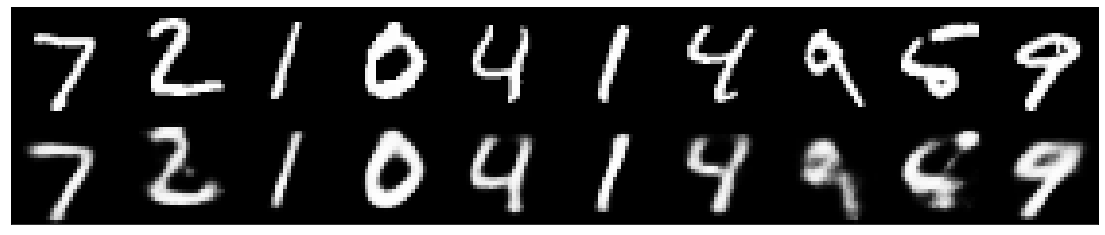

Epoch 27/30
469/469 [==============================] - 3s 6ms/step - loss: 109.7658 - val_total_loss: 109.2608
Epoch 28/30
469/469 [==============================] - 3s 6ms/step - loss: 109.6827 - val_total_loss: 109.0930
Epoch 29/30
469/469 [==============================] - 3s 6ms/step - loss: 109.5567 - val_total_loss: 109.0442
Epoch 30/30
469/469 [==============================] - 3s 6ms/step - loss: 109.6696 - val_total_loss: 109.0601


In [ ]:
vae.fit(xTrain,epochs=30, batch_size=128,validation_data=(xTest,xTest),callbacks=[pltFig]) #обучение

In [ ]:
#Вывод картинок на экран
def plot_images(generator,examples=10,dim=(1,10),figsize=(15,15)):
  k=1.1
  noise=np.random.normal(loc=0,scale=1,size=[1,latent_dim])

  im_arr=[generator.predict((k**i)*noise) for i in range(0,examples)]
  im_arr=np.array(im_arr).reshape(examples,28,28)

  plt.figure(figsize=figsize)
  for i in range(im_arr.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)
    plt.imshow(im_arr[i],interpolation="nearest")
    plt.axis("off")
  plt.tight_layout()


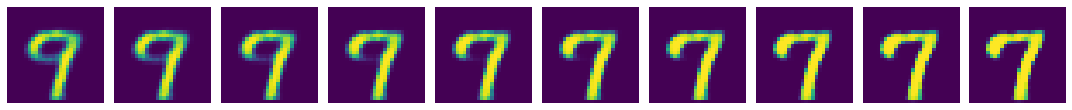

In [ ]:
plot_images(decoder)